In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# Preprocess dataset (Outputs: ids, trial_nums, predictors_df, outcomes_df, outcomes_df_shuffled)
# Import dataset
df = pd.read_csv("./../Datasets/kieranFeatures_1-31_21-Jan-2025_avgof3_rawSA.csv").replace([np.inf, -np.inf], np.nan)

# Create Low vs High Columns
df["Lv_1_Lo"] = (df["SA1"] < 5).astype(np.bool_)
df["Lv_2_Lo"] = (df["SA2"] < 5).astype(np.bool_)
df["Lv_3_Lo"] = (df["SA3"] < 5).astype(np.bool_)
df["Tot_Lo"] = (df["SAtotal"] < 15).astype(np.bool_)

# Impute missing values with mean of column
for col in df.columns:
    df[col] = df[col].fillna(value = df[col].mean())

# Split up dataset
ids = df["ID"].astype(np.uint8)
predictors_df = df.drop(columns = ["ID", "trialNum", "SA1", "SA2", "SA3", "SAtotal", "Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]).astype(np.float64)
outcomes_df = df[["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo", "SA1", "SA2", "SA3", "SAtotal"]]
outcomes_df_shuffled = outcomes_df.copy()

# Shuffle labels for shuffled data
outcomes_df_shuffled["Lv_1_Lo"] = np.random.permutation(outcomes_df_shuffled["Lv_1_Lo"])
outcomes_df_shuffled["Lv_2_Lo"] = np.random.permutation(outcomes_df_shuffled["Lv_2_Lo"])
outcomes_df_shuffled["Lv_3_Lo"] = np.random.permutation(outcomes_df_shuffled["Lv_3_Lo"])
outcomes_df_shuffled["Tot_Lo"] = np.random.permutation(outcomes_df_shuffled["Tot_Lo"])

# Divide up dataframe
ids = df["ID"]
ECG_df = df.loc[:, [col for col in df if col.startswith("ECG")]]
EDA_df = df.loc[:, [col for col in df if col.startswith("EDA")]]
EEG_df = df.loc[:, [col for col in df if col.startswith("EEG")]]
EYE_df = df.loc[:, [col for col in df if col.startswith("EYE")]]
fNIRS_df = df.loc[:, [col for col in df if col.startswith("fNIRS")]]
RSP_df = df.loc[:, [col for col in df if col.startswith("RSP")]]
sensor_dfs = [(ECG_df, "ECG"), (EDA_df, "EDA"), (EEG_df, "EEG"), (EYE_df, "EYE"), (fNIRS_df, "fNIRS"), (RSP_df, "RSP")]

# Free up memory
del col, df, predictors_df

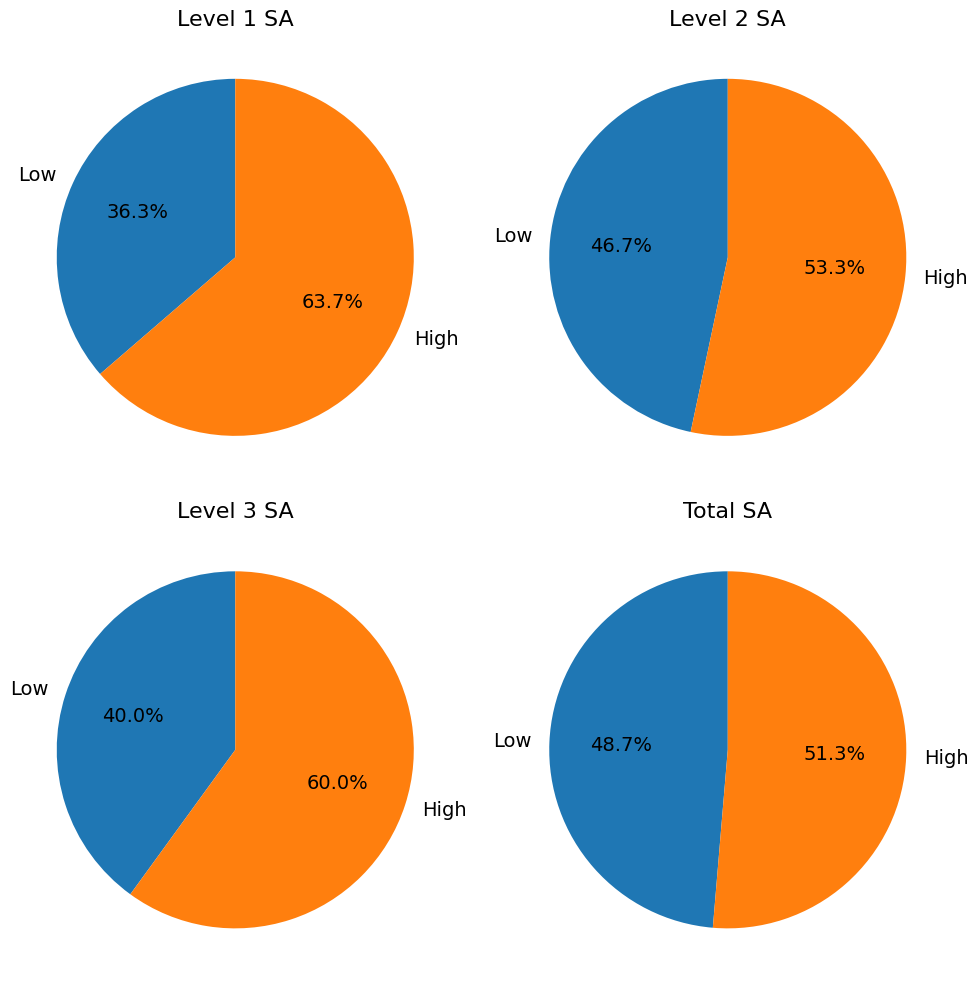

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 2, figsize = (10, 10))
labels = ["Low", "High"]
colors = ["C0", "C1"]

ax1[0].set_title("Level 1 SA", fontsize = 16)
ax1[0].pie([np.sum(outcomes_df["Lv_1_Lo"]), np.sum(~outcomes_df["Lv_1_Lo"])], labels = labels, colors = colors, autopct = "%1.1f%%", startangle = 90, textprops = {"fontsize": 14})

ax1[1].set_title("Level 2 SA", fontsize = 16)
ax1[1].pie([np.sum(outcomes_df["Lv_2_Lo"]), np.sum(~outcomes_df["Lv_2_Lo"])], labels = labels, colors = colors, autopct = "%1.1f%%", startangle = 90, textprops = {"fontsize": 14})

ax2[0].set_title("Level 3 SA", fontsize = 16)
ax2[0].pie([np.sum(outcomes_df["Lv_3_Lo"]), np.sum(~outcomes_df["Lv_3_Lo"])], labels = labels, colors = colors, autopct = "%1.1f%%", startangle = 90, textprops = {"fontsize": 14})

ax2[1].set_title("Total SA", fontsize = 16)
ax2[1].pie([np.sum(outcomes_df["Tot_Lo"]), np.sum(~outcomes_df["Tot_Lo"])], labels = labels, colors = colors, autopct = "%1.1f%%", startangle = 90, textprops = {"fontsize": 14})

fig.tight_layout()